**Demand Forecasting:**  
- At any given point in time, the optimal price  P∗  depends on a forecast of demand  Dˆ , as well as many other factors,
P∗t=f(Dˆt,…,other factors,…), and is typically the solution to an optimization problem that maximizes a metric such as revenue or profit.  
- A price-optimization algorithm uses a demand forecasting model to predict demand at various price points, and includes business constraints to maximize potential profit.  
- Maximum revenue is an optimization problem, involving dynamic programming.

**Consider the problem of demand estimation for $n$ substituable products.**  
2 important problems:  
- turned-away demand when items are sodl out (**spilled demand**)  
- properly accounting for substitution effects among related items (**recaptured demands**)  

For simplicity, most retail demand forecasts rely on **time-series** models of **observed sales data**, which treat each stock keeping unit (SKU) as receiving an independent stream of requests.  
- if spilled demand is ignored the resulting demand forecasts might be **negatively biased**.  

**Recaptured demand**: substitute products that are available  
- ignoring this leads to an **overestimation bias**. 

**true demand = observed demand + spill demand - recapture demand + other stuff + noise**

Estimating spilled and recaptured demand is called **demand untruncation** or **uncensoring methods**.

One of the most popular is **Expected-Maximization (EM) Algorithm**.  
- works by using alternating steps of computing conditional expected values of the parameter estimates to obtain an expected log-likelihood function (the E-step) and maximizing this function to obtain improved estimates (the M-step).  
- limited to untruncating sales history for individual SKUs and disregard recapture effects from substitute products.

# Walmart Dataset

We will use sales data from Walmart to estimate future demand of departments within stores (think of the stores' aggregate department sales as a proxy for all products' demand in that department, at that store).

A little about deep learning:  
**Dicriminative Deep Learning:** Uber ride time, mostly from consumer perspectives, content filtering, stock prediction, demand forecasting, taking data that's already there. You give the data, the model predicts the label.  
$Y = f(X)$.  

**Generative Deep Learning:** you give a label, and the model generates the data.  
- Ex: giving a description of an image, the model produces the actual image. You give a prompt, ChatGPT writes the essay.  

$X = g(Y)$

Usually:  
Discriminative $\implies$ **Supervised**  
Generative $\implies$ **Unsupervised**

Generative DL is great because it gives businesses consumer-facing products that everyone can appreciate.

In [4]:
import pandas as pd
import os
data_path = 'data/01_part_1/'

**Description of Data - features.csv**  

Contains data related to the store, department, and regional activity for the given dates, such as:  
the store number, the week  
the average temperature in the region  
the cost of fuel in the region  
five anonymous variables (called MarkDown 1, 2, 3, 4, 5) related to promotional markdowns that Walmart is running  
  MarkDown data is not available for all stores at all times  
the consumer price index (CPI)  
the unemployment rate  
a binary variable that indicates whether the week is a special holiday or not  
  the four holidays (Super Bowl, Labor Day, Thanksgiving, Christmas), fall within the following weeks in the data  
  not all holidays are in the data, and dates are in the form: dd-mm-yy  
  Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13  
  Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13  
  Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13  
  Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [5]:
features_data = pd.read_csv(data_path + 'features.csv')
features_data.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


**Pandas**:  stands for panel data (involves entities and time)  
- Creates DataFrames (objects) with rows and columns

**Description of Data - stores.csv**  
Contains anonymized information about the 45 stores  
These variables indicate the type of store and the size of the store

In [6]:
stores_data = pd.read_csv(data_path + 'stores.csv')
stores_data.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [7]:
stores_data['Store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int64)

In [8]:
stores_data['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

**Description of Data - train.csv**  
Contains the labels for the training data  
Covers 2010-02-05 to 2012-11-01  
It includes the store number, the department number, and the date (week)  
Weekly sales for the given department in the given store  
It also includes whether the week is a special holiday or not

In [9]:
train_data = pd.read_csv(data_path + 'train.csv')
train_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [10]:
features_data.shape, stores_data.shape, train_data.shape

((8190, 12), (45, 3), (421570, 5))

In [11]:
data = pd.merge(features_data, stores_data, on=["Store"], how="outer")

data

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False,B,118221
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False,B,118221
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False,B,118221
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False,B,118221


In [12]:
data = pd.merge(data, train_data, on=["Store", "Date", "IsHoliday"], how="inner")
data

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,1,24924.50
1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2,50605.27
2,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,3,13740.12
3,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,4,39954.04
4,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,5,32229.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,93,2487.80
421566,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,94,5203.31
421567,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,95,56017.47
421568,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,97,6817.48


## Splitting Data:  
We will do a **time-series** split into a training and a testing set, where thr training set contains data that occurred **before** the data in the testing set.  
Careful to prevent data leakage, i.e. a lookahead bias, at this step.  

**Why do we split data?**  
We have to simulate the 'real' environment as much as possible before releasing it into the wild. Splitting into training and testing ensures that the model doesn't just work well in research, but also in production/real-world scenarios. We don't want to let the model memorize any testing data, so that we can see if the patterns it memorized in the training set are actually applicable/generalizable on the test set.

In [13]:
data.shape

(421570, 16)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Date          421570 non-null  object 
 2   Temperature   421570 non-null  float64
 3   Fuel_Price    421570 non-null  float64
 4   MarkDown1     150681 non-null  float64
 5   MarkDown2     111248 non-null  float64
 6   MarkDown3     137091 non-null  float64
 7   MarkDown4     134967 non-null  float64
 8   MarkDown5     151432 non-null  float64
 9   CPI           421570 non-null  float64
 10  Unemployment  421570 non-null  float64
 11  IsHoliday     421570 non-null  bool   
 12  Type          421570 non-null  object 
 13  Size          421570 non-null  int64  
 14  Dept          421570 non-null  int64  
 15  Weekly_Sales  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


In [15]:
data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

data

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
Date,,,,,,,,,,,,,,,
2010-02-05,1,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,1,24924.50
2010-02-05,35,27.19,2.784,NaN,NaN,NaN,NaN,NaN,135.352461,9.262,False,B,103681,3,14612.19
2010-02-05,35,27.19,2.784,NaN,NaN,NaN,NaN,NaN,135.352461,9.262,False,B,103681,4,26323.15
2010-02-05,35,27.19,2.784,NaN,NaN,NaN,NaN,NaN,135.352461,9.262,False,B,103681,5,36414.63
2010-02-05,35,27.19,2.784,NaN,NaN,NaN,NaN,NaN,135.352461,9.262,False,B,103681,6,11437.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-26,13,46.97,3.755,10192.49,364.57,150.0,1714.15,5563.92,131.193097,5.621,False,A,219622,49,7770.71
2012-10-26,13,46.97,3.755,10192.49,364.57,150.0,1714.15,5563.92,131.193097,5.621,False,A,219622,50,1486.00
2012-10-26,13,46.97,3.755,10192.49,364.57,150.0,1714.15,5563.92,131.193097,5.621,False,A,219622,52,4738.93


In [16]:
# An approximate 70/30 Time Series Split

training_data = data.loc[:'2011', :].copy()

testing_data = data.loc['2012':, :].copy()

In [17]:
training_data.tail()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
Date,,,,,,,,,,,,,,,
2011-12-30,19,31.65,3.566,6234.22,50438.17,210.34,1457.96,2373.94,136.643258,7.866,True,A,203819,32,12122.50
2011-12-30,19,31.65,3.566,6234.22,50438.17,210.34,1457.96,2373.94,136.643258,7.866,True,A,203819,33,4875.31
2011-12-30,19,31.65,3.566,6234.22,50438.17,210.34,1457.96,2373.94,136.643258,7.866,True,A,203819,34,12897.00
2011-12-30,20,36.35,3.389,6918.65,97740.99,270.38,1648.03,2852.19,212.403576,7.082,True,A,203742,26,9847.01
2011-12-30,20,36.35,3.389,6918.65,97740.99,270.38,1648.03,2852.19,212.403576,7.082,True,A,203742,25,15816.08


In [18]:
testing_data.head()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
Date,,,,,,,,,,,,,,,
2012-01-06,26,22.94,3.439,3352.77,17442.27,117.1,468.31,6344.32,136.698129,7.467,False,A,152513,48,117.00
2012-01-06,26,22.94,3.439,3352.77,17442.27,117.1,468.31,6344.32,136.698129,7.467,False,A,152513,49,1920.57
2012-01-06,26,22.94,3.439,3352.77,17442.27,117.1,468.31,6344.32,136.698129,7.467,False,A,152513,52,946.36
2012-01-06,26,22.94,3.439,3352.77,17442.27,117.1,468.31,6344.32,136.698129,7.467,False,A,152513,55,10478.94
2012-01-06,26,22.94,3.439,3352.77,17442.27,117.1,468.31,6344.32,136.698129,7.467,False,A,152513,56,168.69


In [19]:
training_data[['Store', 'Dept']].value_counts().sort_index().unstack()

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,79.0,100.0,100.0,15.0
2,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,17.0
3,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,NaN,33.0,100.0,100.0,97.0,23.0,NaN
4,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,17.0
5,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,NaN,49.0,100.0,100.0,84.0,11.0,NaN
6,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,17.0
7,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,73.0,100.0,100.0,100.0,98.0,NaN
8,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,NaN,100.0,100.0,13.0
9,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,2.0,46.0,100.0,100.0,9.0,11.0,NaN


In [20]:
testing_data[['Store', 'Dept']].value_counts().unstack()

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,...,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,22.0
2,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,...,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,25.0
3,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,...,43.0,43.0,43.0,NaN,21.0,43.0,43.0,43.0,13.0,NaN
4,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,...,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,25.0
5,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,...,43.0,43.0,43.0,NaN,25.0,43.0,43.0,43.0,12.0,NaN
6,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,...,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,23.0
7,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,...,43.0,43.0,43.0,43.0,42.0,43.0,43.0,43.0,43.0,1.0
8,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,...,43.0,43.0,43.0,43.0,43.0,43.0,3.0,43.0,43.0,22.0
9,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,...,43.0,43.0,43.0,NaN,28.0,43.0,43.0,NaN,3.0,NaN


## Imputing Null Values:  
- We must be very careful to prevent any data leakage, i.e. a lookahead bias, at this step by imputing with values not known at the time the prediction was made.  

- We will fill in missing values in the testing set using the a statistic computed from the training data, which is the only information we would have known at the time of training and predicting on the testing set.

You can also fill with the mean as you go along in the training set, row by row, but we're keeping it simple.

Heuristic: at a *fixed point in time*, what would I know about the data?

In [21]:
data.isna().sum()

Store                0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday            0
Type                 0
Size                 0
Dept                 0
Weekly_Sales         0
dtype: int64

In [22]:
training_data.isna().sum()

Store                0
Temperature          0
Fuel_Price           0
MarkDown1       270432
MarkDown2       273978
MarkDown3       271016
MarkDown4       273090
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday            0
Type                 0
Size                 0
Dept                 0
Weekly_Sales         0
dtype: int64

In [23]:
testing_data.isna().sum()

Store               0
Temperature         0
Fuel_Price          0
MarkDown1         457
MarkDown2       36344
MarkDown3       13463
MarkDown4       13513
MarkDown5           0
CPI                 0
Unemployment        0
IsHoliday           0
Type                0
Size                0
Dept                0
Weekly_Sales        0
dtype: int64

<Axes: xlabel='Date'>

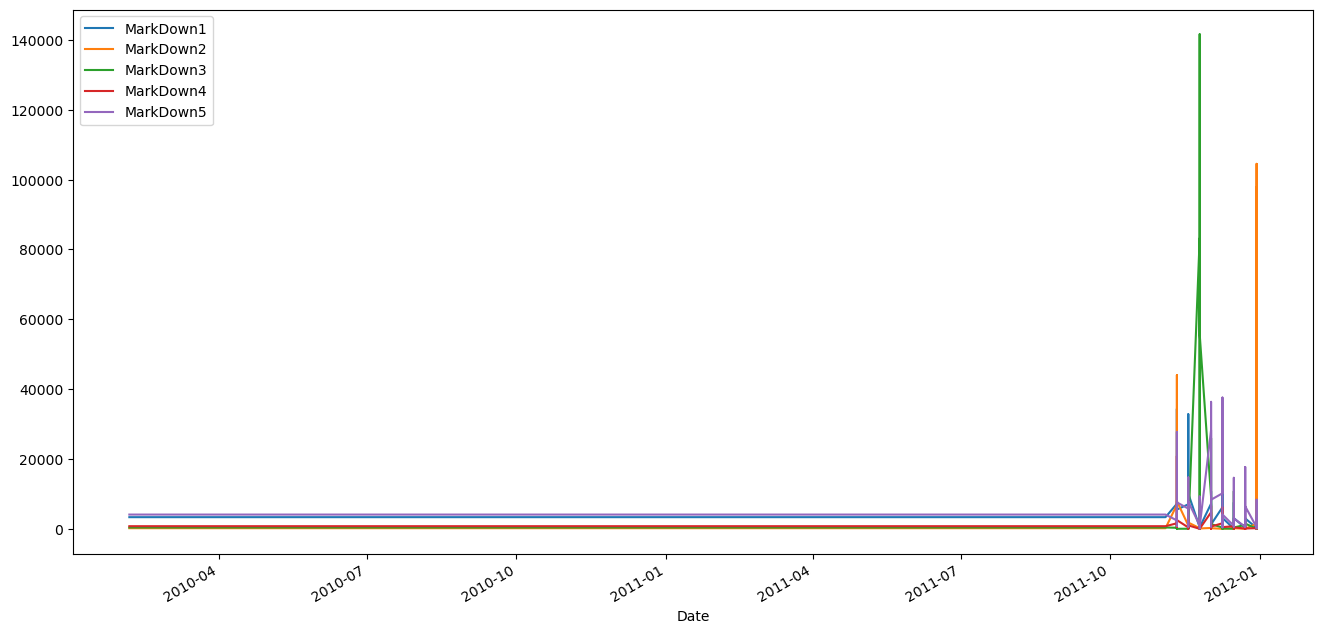

In [24]:
training_data[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].fillna(training_data[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].median()).plot(figsize=(16,8))

In [25]:
testing_data.isna().sum()

Store               0
Temperature         0
Fuel_Price          0
MarkDown1         457
MarkDown2       36344
MarkDown3       13463
MarkDown4       13513
MarkDown5           0
CPI                 0
Unemployment        0
IsHoliday           0
Type                0
Size                0
Dept                0
Weekly_Sales        0
dtype: int64

We can probably safely fill all missing values with zero. For the markdowns this means that there was no markdown.

In [26]:
training_data.fillna(0, inplace=True)
testing_data.fillna(0, inplace=True)

## EDA and Descriptive Analytics on the Training Set

- See what we can discover using **exploratory data analysis**  
- Prevent lookahead vua on any generalizaton error estimates, only do deep analysis on the training dataset.  
- Helps with:  
    - determine what class of models we want to use build low generalization error predictions   
    -  create new variables (i.e. feature engineering) that help to extract more signal from the data and can be used in the models to generate better predictions.  
- Later, we will see a way to extract features using an algorithm, rather than creating features on our own.  
- We will also see how deep learning can be used as a nonlinear algorithmic feature extraction and model builder.

In [27]:
training_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,294132.0,22.180178,12.780170,1.000,11.000000,22.000000,33.000000,45.000000
Temperature,294132.0,58.909079,18.934062,-2.060,45.260000,60.420000,73.340000,100.140000
Fuel_Price,294132.0,3.209664,0.439060,2.472,2.808000,3.129000,3.595000,4.211000
MarkDown1,294132.0,365.333355,1934.134759,0.000,0.000000,0.000000,0.000000,34348.140000
MarkDown2,294132.0,535.068938,5193.032485,0.000,0.000000,0.000000,0.000000,104519.540000
MarkDown3,294132.0,649.096663,6610.541248,-0.870,0.000000,0.000000,0.000000,141630.610000
MarkDown4,294132.0,109.561983,695.518638,0.000,0.000000,0.000000,0.000000,20834.370000
MarkDown5,294132.0,521.536105,2698.759858,0.000,0.000000,0.000000,0.000000,37581.270000
CPI,294132.0,169.529527,38.464447,126.064,131.901968,182.077986,211.096358,223.249677
Unemployment,294132.0,8.232486,1.865189,4.420,7.287000,8.058000,8.684000,14.313000


<Axes: ylabel='Frequency'>

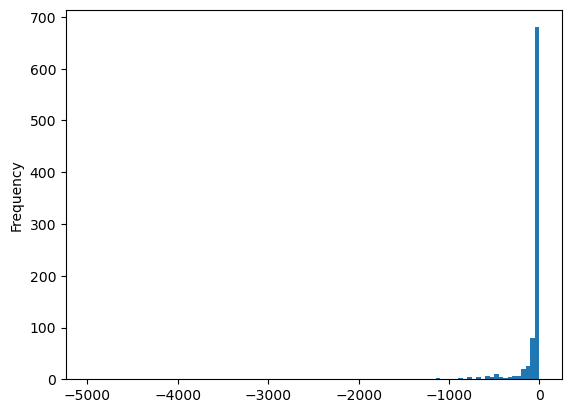

In [28]:
training_data.loc[training_data['Weekly_Sales']<0, 'Weekly_Sales'].plot(kind='hist', bins=100)

In [29]:
# We will only keep rows where we have nonnegative weekly sales, as this is a data error

training_data = training_data[training_data['Weekly_Sales']>=0]

testing_data = testing_data[testing_data['Weekly_Sales']>=0]

In [30]:
training_data['Weekly_Sales'].describe().T

count    293259.000000
mean      16153.473574
std       22978.445289
min           0.000000
25%        2179.585000
50%        7775.200000
75%       20412.780000
max      693099.360000
Name: Weekly_Sales, dtype: float64

<Axes: ylabel='Frequency'>

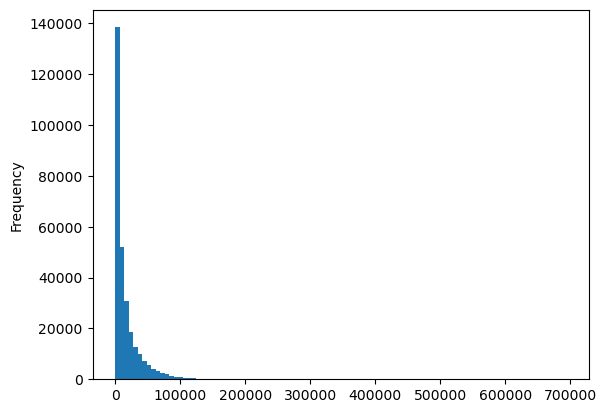

In [31]:
training_data['Weekly_Sales'].plot(kind='hist', bins=100)

In [32]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

<Axes: >

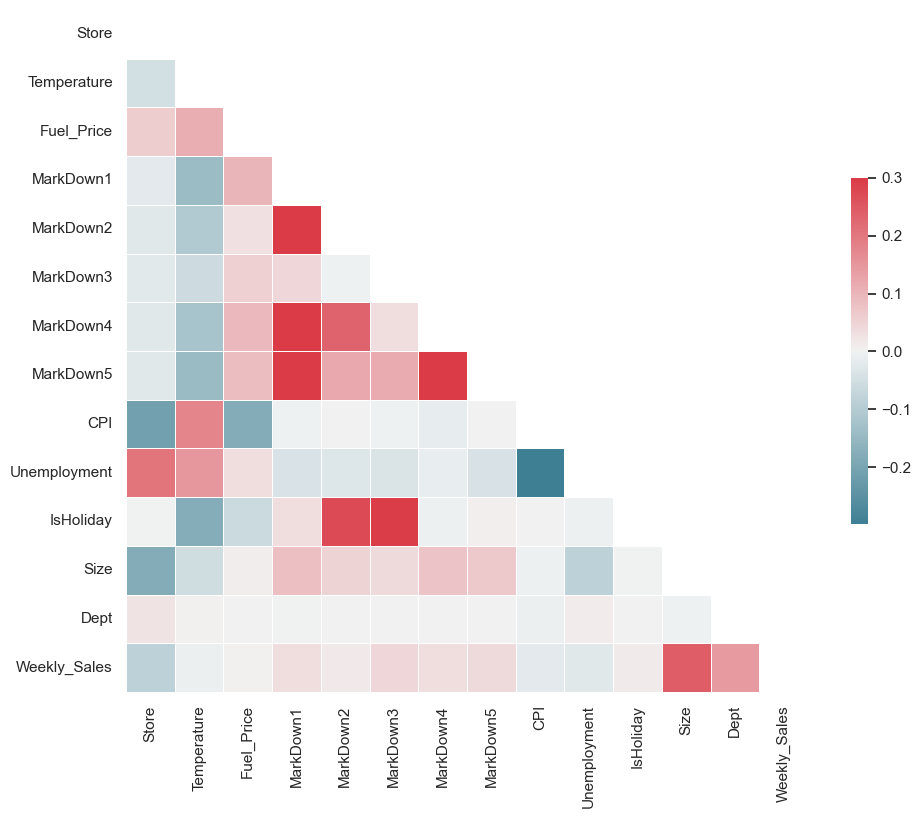

In [33]:
sns.set(style="white")

# Compute the correlation matrix
corr = training_data.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Observations: looks like **store size** and **department** play the largest roles in determining weekly sales.

- No surprises here.  

- Discounts are correlated and higher unemployment means lower Consumer Price Index.  

- More interestingly, it appears that **higher department numbers** have **higher sales**. Maybe because they are newer?  

- Also: 
    - larger stores $\rightarrow$ more sales   
    - discounts $\rightarrow$ higher sales values  
    - larger unemployment $\rightarrow$ fewer sales.  

- **Little relationship** between holidays, temperatures or fuelprices with our weekly sales.  

Text(0.5, 1.0, 'Fuel Price vs. Sales')

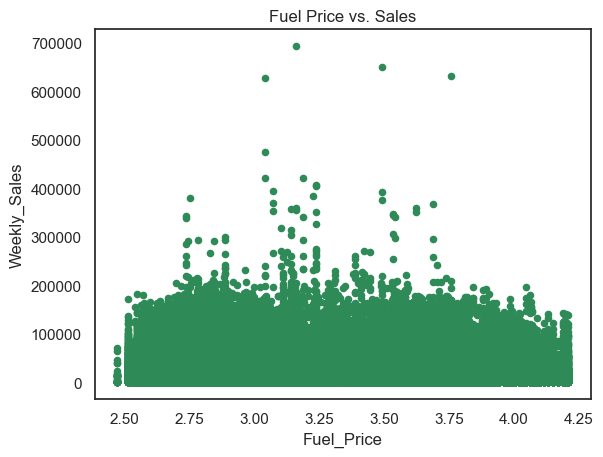

In [34]:
training_data.plot.scatter(x='Fuel_Price', y='Weekly_Sales', c = 'seagreen')
plt.title("Fuel Price vs. Sales")

Text(0.5, 1.0, 'Temperature vs. Weekly Sales')

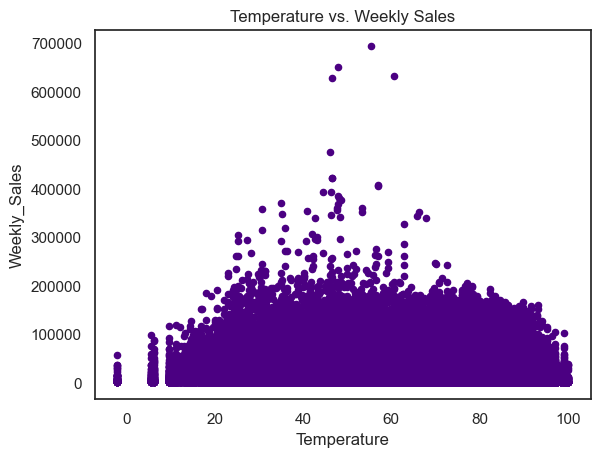

In [35]:
training_data.plot.scatter(x='Temperature', y='Weekly_Sales', c = 'indigo')
plt.title("Temperature vs. Weekly Sales")

Text(0.5, 1.0, 'Store size vs. Weekly Sales')

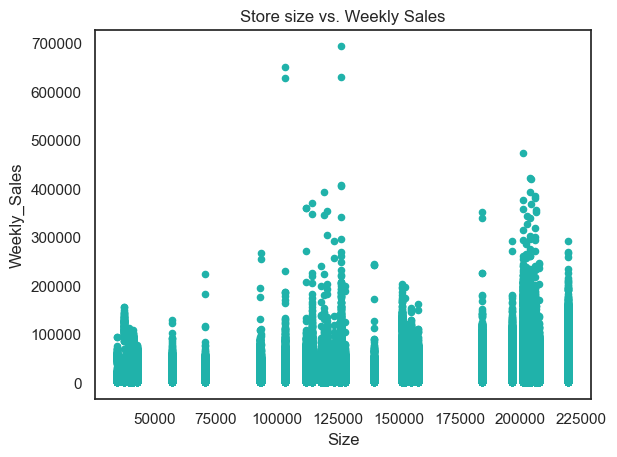

In [36]:
training_data.plot.scatter(x='Size', y='Weekly_Sales', c = 'lightseagreen')
plt.title('Store size vs. Weekly Sales')

Text(0.5, 1.0, 'Store vs. Weekly Sales')

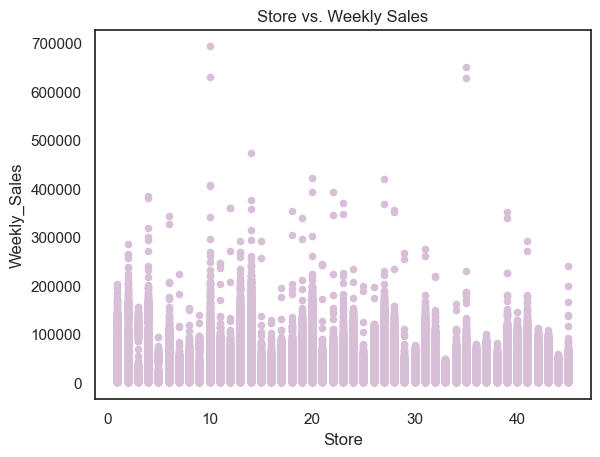

In [37]:
training_data.plot.scatter(x='Store', y='Weekly_Sales', c = 'thistle')
plt.title("Store vs. Weekly Sales")

Text(0.5, 1.0, 'Store Type vs. Weekly Sales')

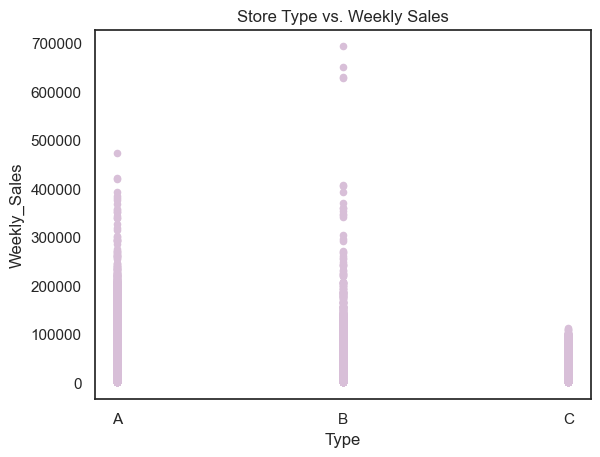

In [38]:
training_data.plot.scatter(x='Type', y='Weekly_Sales', c = 'thistle')
plt.title('Store Type vs. Weekly Sales')

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

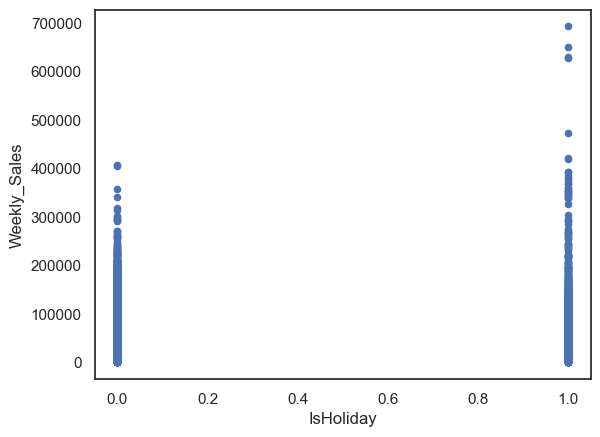

In [39]:
training_data['IsHoliday'] = np.where(training_data['IsHoliday'], 1, 0)
testing_data['IsHoliday'] = np.where(testing_data['IsHoliday'], 1, 0)

training_data.plot.scatter(x='IsHoliday', y='Weekly_Sales')

- We notice that type C stores have fewer sales, in general, and holidays clearly show more sales.  

- Although no further relationships appear evident from this analysis, there appears to be some outliers in our data. Let's take a bit of a closer look at these.

In [40]:
# Do we notice any patterns?

training_data.loc[training_data['Weekly_Sales'] > 300_000]

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
Date,,,,,,,,,,,,,,,
2010-11-26,20,46.66,3.039,0.00,0.00,0.00,0.00,0.00,204.962100,7.484,1,A,203742,72,422306.25
2010-11-26,18,40.81,3.070,0.00,0.00,0.00,0.00,0.00,132.836933,9.331,1,B,120653,72,353008.64
2010-11-26,4,48.08,2.752,0.00,0.00,0.00,0.00,0.00,126.669267,7.127,1,A,205863,72,381072.11
2010-11-26,27,46.67,3.186,0.00,0.00,0.00,0.00,0.00,136.689571,8.021,1,A,204184,72,420586.57
2010-11-26,12,47.66,3.162,0.00,0.00,0.00,0.00,0.00,126.669267,14.313,1,B,112238,72,359995.60
2010-11-26,28,47.66,3.162,0.00,0.00,0.00,0.00,0.00,126.669267,14.313,1,A,206302,72,355356.39
2010-11-26,10,55.33,3.162,0.00,0.00,0.00,0.00,0.00,126.669267,9.003,1,B,126512,72,693099.36
2010-11-26,6,65.79,2.735,0.00,0.00,0.00,0.00,0.00,213.267296,7.007,1,A,202505,72,342578.65
2010-11-26,14,46.15,3.039,0.00,0.00,0.00,0.00,0.00,182.783277,8.724,1,A,200898,72,474330.10


Dates look like they correspond to holiday times, for both years. But not all of these are picked up by the holiday column! We probably need to add some more variables:  
- Looks like sales spike around **Black Friday**, so we should probably add a dummy variable for that.  
- Also, Christmas appears here and there. Since it is not considered a holiday in our data, we will also make a dummy for this day.  

This is known as **feature engineering**

In [41]:
training_data.loc[training_data['Weekly_Sales'] >240_000].index.value_counts()

Date
2010-11-26    23
2011-11-25    22
2010-12-24    14
2011-12-23     9
2010-12-17     2
2010-02-05     1
2011-08-26     1
Name: count, dtype: int64

- Except for a handful spurious other dates, it appears that the two days before Christmas and Black Friday will do the job.  

- We are now ready to start building new variables that encode, hopefully, better signal from the data to the target sales variable.

## Deriving Features for Forecasting

- We should spend a lot of time trying to come up with new variables that are combinations of the existing variables that are better representations of the data.  

We think store-specific categories, as well as the holiday indicator contain important information.  

From our earlier analysis, it has turned out that the date may be a useful piece of information.  
    - It is good to distinguish between different months in our model  
    - We will create 12 dummy variables; one for each month.  

We will then turn our attention to special dates  
    - One variable for Christmas, one for Black Friday  

**Dummy variable trap**: multicollinearity
    - Variables are pairwise correlated, but independent variables work better for regression.  
    - Has to do with choosing a representation (manual feature creation)  
        - Choosing new features that might represent the data better

We should also normalize our numerical variables, i.e. turn them into Z-scores.

In [42]:
# Make sure we can later recognize what a dummy once belonged to

from datetime import datetime

training_testing_data = [training_data, testing_data]

for df in training_testing_data:
  df['Type'] = 'Type_' + df['Type'].map(str)
  df['Store'] = 'Store_' + df['Store'].map(str)
  df['Dept'] = 'Dept_' + df['Dept'].map(str)
  df['IsHoliday'] = 'IsHoliday_' + df['IsHoliday'].map(str)

  df['Month'] = 'Month_' + df.index.month.map(str)

  df['Black_Friday'] = np.where((df.index==datetime(2010, 11, 26).date()) | (df.index==datetime(2011, 11, 25).date()), 'yes', 'no')
  df['Pre_Christmas'] = np.where((df.index==datetime(2010, 12, 23).date()) | (df.index==datetime(2010, 12, 24).date()) | (df.index==datetime(2011, 12, 23).date()) | (df.index==datetime(2011, 12, 24).date()), 'yes', 'no')
  df['Black_Friday'] = 'Black_Friday_' + df['Black_Friday'].map(str)
  df['Pre_Christmas'] = 'Pre_Christmas_' + df['Pre_Christmas'].map(str)

In [43]:
# Create dummies for store features and for holiday indicator

for df, i in zip(training_testing_data, range(2)):
  type_dummies = pd.get_dummies(df['Type'], drop_first=True, dtype=float)
  store_dummies = pd.get_dummies(df['Store'], drop_first=True, dtype=float)
  dept_dummies = pd.get_dummies(df['Dept'], drop_first=True, dtype=float)
  holiday_dummies = pd.get_dummies(df['IsHoliday'], drop_first=True, dtype=float)

  month_dummies = pd.get_dummies(df['Month'], drop_first=True, dtype=float)

  Black_Friday_dummies = pd.get_dummies(df['Black_Friday'], drop_first=True, dtype=float)
  Pre_christmas_dummies = pd.get_dummies(df['Pre_Christmas'], drop_first=True, dtype=float)

  if i == 1:
    # Nov, Dec are not in the testing sample, so we must add the columns manually
    df['Month_11'] = 0
    df['Month_12'] = 0

  training_testing_data[i] = pd.concat([df,
                                        type_dummies, store_dummies, dept_dummies, holiday_dummies,
                                        month_dummies,
                                        Black_Friday_dummies, Pre_christmas_dummies],
                                        axis=1)

In [44]:
training_data = training_testing_data[0]

testing_data = training_testing_data[1]

In [45]:
# Normalize the numerical variables using means and stds from the TRAINING DATA
for df in training_testing_data:
  df[['Unemployment', 'Temperature', 'Fuel_Price', 'CPI', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']] = (df[['Unemployment', 'Temperature', 'Fuel_Price', 'CPI', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']] - training_testing_data[0][['Unemployment', 'Temperature', 'Fuel_Price', 'CPI', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].mean())/(training_testing_data[0][['Unemployment', 'Temperature', 'Fuel_Price', 'CPI', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].std())

In [46]:
training_data.isna().sum().sum(), testing_data.isna().sum().sum()

(0, 0)

In [47]:
training_data.shape, testing_data.shape

((293259, 156), (127026, 156))

How can we select the variables that we think are most important?

<Axes: >

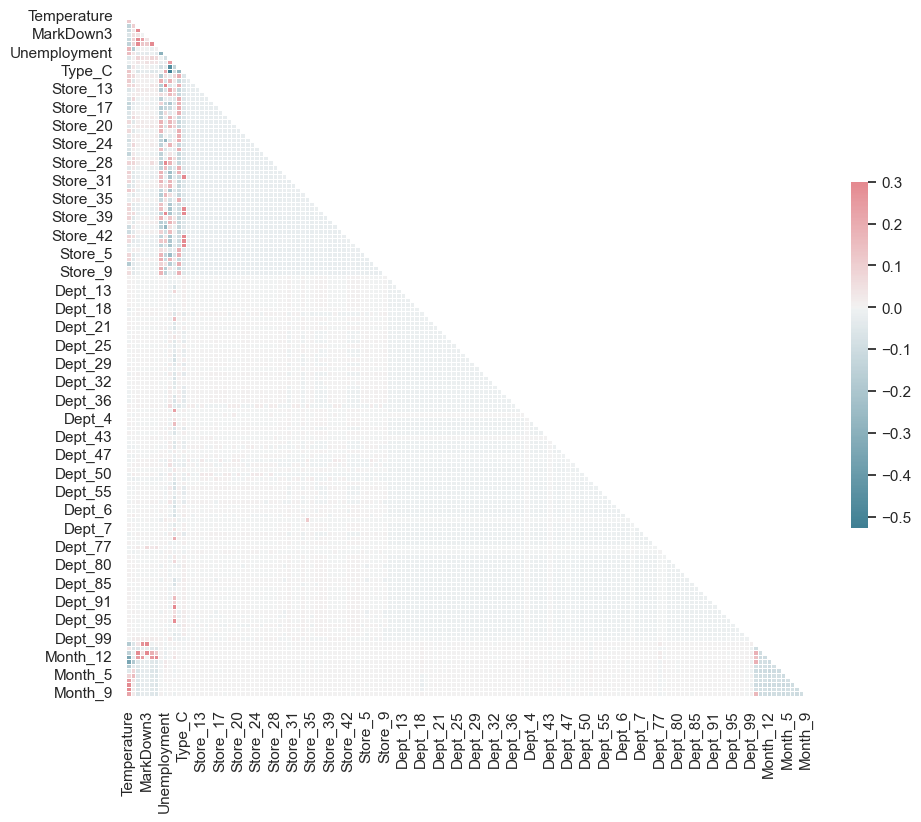

In [48]:
sns.set(style="white")

# Compute the correlation matrix
corr = training_data.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [49]:
np.abs(training_data.corr(numeric_only=True)[['Weekly_Sales']]).sort_values(by='Weekly_Sales', ascending=False).head(20)

,Weekly_Sales
Weekly_Sales,1.000000
Dept_92,0.313437
Dept_95,0.288222
Size,0.242893
Dept_38,0.240762
Dept_72,0.196681
Dept_90,0.155331
Dept_40,0.153379
Dept_2,0.148335
Type_B,0.128456


In [50]:
# Let's separate our data into X and Y

X_train = training_data[training_data.columns.drop('Weekly_Sales')].select_dtypes(include=np.number)
Y_train = training_data[['Weekly_Sales']]

X_test = testing_data[testing_data.columns.drop('Weekly_Sales')].select_dtypes(include=np.number)
Y_test = testing_data[['Weekly_Sales']]

In [51]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((293259, 148), (127026, 148), (293259, 1), (127026, 1))

How should we select which variables to use to predict future weekly sales per store and per department?  

We will see an algorithmic solution to feature engineering.

## Using Principal Components Algorithm to Learn Features

**PCA**: way to create new features by following an algorithm that projects high-dimensional data into lower-dimensional subspaces whose axes correspond to new features.  
- Allows us to **learn** features that are relevant to our prediction problem  
- Finds new directions along which the variation of the data is maximized  
- These directions are orthogonal to one another (uncorrelated)

Algorithmic feature engineering + linear regression = **Neural Network**  

**Neural Network**: Nonlinear PCA + Nonlinear Regression

In [52]:
import tensorflow as tf
images_path = 'images'

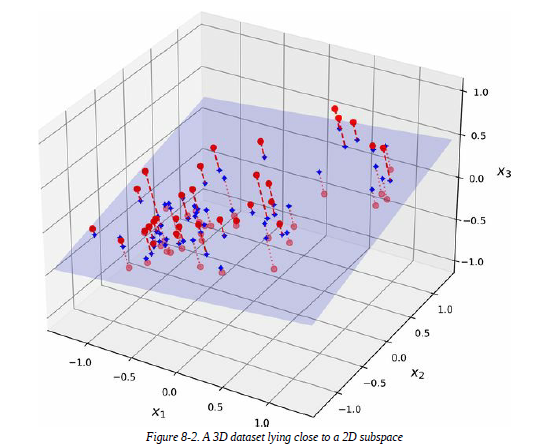

In [53]:
tf.keras.preprocessing.image.load_img(os.path.join(images_path, 'PCA_1.png'))

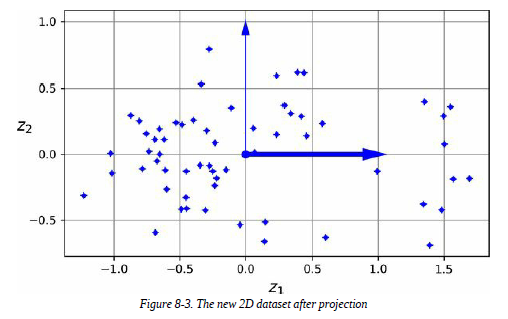

In [54]:
tf.keras.preprocessing.image.load_img(os.path.join(images_path, 'PCA_2.png'))

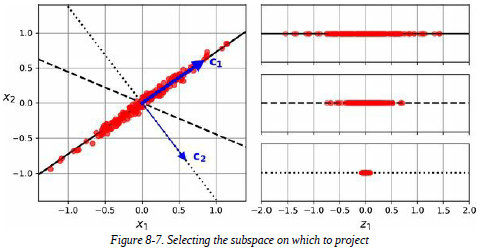

In [55]:
tf.keras.preprocessing.image.load_img(os.path.join(images_path, 'PCA_3.png'))

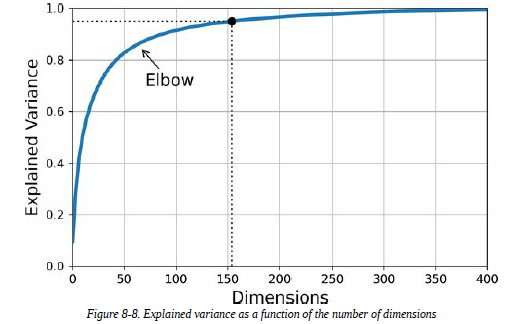

In [56]:
tf.keras.preprocessing.image.load_img(os.path.join(images_path, 'PCA_4.png'))

## What is Learning?

Learning parameters that minimize a loss function in an iterative way.

Every machine learning (and deep learning) algorithm involves finding a set of parameters
wˆ 
(these are sometimes called  β  or  θ ) that minimize total expected (average) error (this is frequently called the loss function or cost function)

$L(w; \mathbf{X}, Y) = \mathbb{E}[\ell(w; (X_1, \dots, X_p, Y)] \approx \frac{1}{n} \sum_{i=1}^n \ell(w; (X_{i,1}, X_{i,2}, \dots, X_{i,p}, Y_i))$  
observed from the data $(X_{i,1}, X_{i,2}, \dots, X_{i,p}), \quad \text{ for } 1 \leq i \leq n_{obs}.$

Common loss functions:  
- MSE  
- Cross-Entropy Log Loss

## Implementing PCA as a Neural Network

Few different ways:  
- Sklearn using SVD  
- Only Numpy -- eigendecomp  
- Using DL software (keras and tf) to implement PCA as a shallow linear autoencoder network.  

**Autoencoder Network**: neural network with special structure  
- Takes input data, converts it to an efficient latent representation, then returns something that looks (hopefully) close to the inputs.  
- 2 parts:  
    - Encoder (recognition network)  
    - Decoder: follows the encoder, converts the internal latent representation to the outputs  

Number of neurons in the output layer must equal the number of inputs.  
Outputs are called **reconstructions** because the autoencoder tries to reconstruct the inputs.  

The cost function contains a **reconstruction loss** that penalizes ghe model when the reconstructions re different from the inputs.  

**Undercomplete**: internal representation has a lower dimensionality than the input data  

If an autoencoder uses only linear activation functions with MSE loss, then it end sup performing the PCA algorithm.

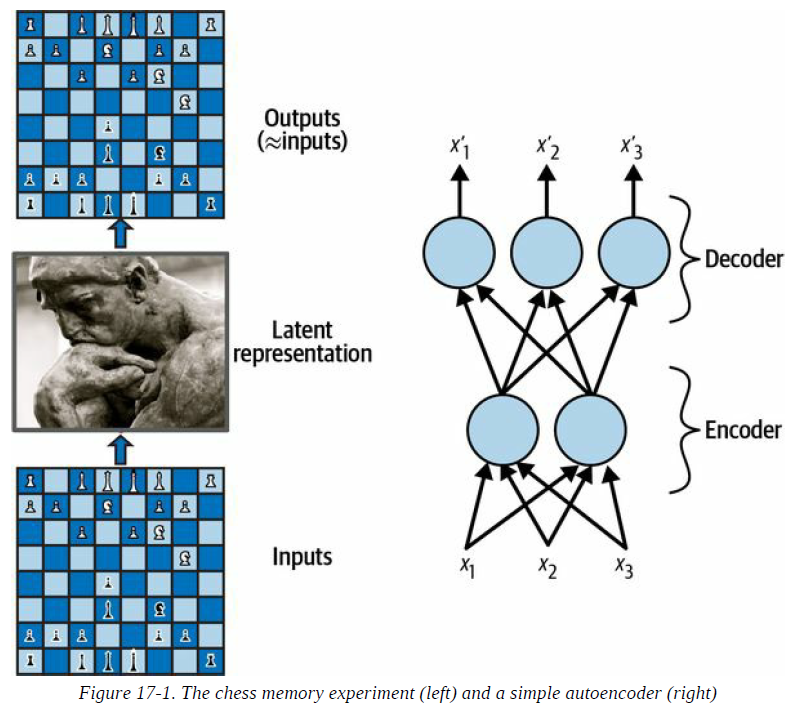

In [57]:
tf.keras.preprocessing.image.load_img(os.path.join(images_path, 'shallow_autoencoder_1.png'))

In [58]:
# We will organize the autoencoder into two subcomponents:
## the encoder - a regular sequential model with a single Dense layer
## the decoder - a regular sequential model with a single Dense layer

# tf.keras.layers.Normalization(axis=-1), # When -1 the last axis of the input is assumed to be a feature dimension and is normalized per index.
# We can ignore the normalization layer because we already normalized our numerical features above (though we could add it for "safety")
encoder = tf.keras.Sequential([tf.keras.layers.InputLayer(shape=(X_train.shape[1], )),
                               tf.keras.layers.Dense(15)])
# The autoencoder's number of outputs must equal the number of inputs
decoder = tf.keras.Sequential([tf.keras.layers.Dense(X_train.shape[1])])

# The autoencoder is a sequential model containing the encoder followed by the decoder
# To perform PCA, we don't use any activation function (i.e. all neurons are linear), and the loss function is MSE
# This is because PCA is a linear transformation
autoencoder = tf.keras.Sequential([encoder, decoder])

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)

autoencoder.compile(loss="mse")

In [59]:
# Note that we only use the inner hidden layer to generate the derived features
# These are known as the "codings"

# This is the built-in training loop
history = autoencoder.fit(X_train, X_train, epochs=10, verbose=True)

codings = encoder.predict(X_train)

codings

Epoch 1/10
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 8s 703us/step - loss: 8217285.5000
Epoch 2/10
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 6s 642us/step - loss: 23131.8379
Epoch 3/10
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 6s 667us/step - loss: 15286.8584
Epoch 4/10
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 7s 754us/step - loss: 12089.0908
Epoch 5/10
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 8s 825us/step - loss: 10385.4668
Epoch 6/10
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 8s 897us/step - loss: 9399.9600
Epoch 7/10
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 9s 977us/step - loss: 8423.5010
Epoch 8/10
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 8002.9014
Epoch 9/10
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 7667.4917
Epoch 10/10
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 9s 999us/step - loss: 7378.7456
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 7s 784us/step


array([[ -25.065245 ,   10.046419 , 2464.7888   , ...,  -48.679646 ,
          44.119328 ,    8.117601 ],
       [ -16.178276 ,    7.111479 , 1688.9459   , ...,  -32.85606  ,
          29.983168 ,    5.208624 ],
       [ -16.512344 ,    7.2896204, 1689.1168   , ...,  -32.98965  ,
          29.905807 ,    4.8933043],
       ...,
       [ -32.74216  ,    8.019868 , 3322.0032   , ...,  -69.231995 ,
          60.72516  ,    9.457497 ],
       [ -31.93367  ,    5.8853474, 3321.5083   , ...,  -74.55164  ,
          63.064724 ,    9.167566 ],
       [ -31.370108 ,    5.9977446, 3321.7405   , ...,  -74.692635 ,
          63.095257 ,    9.386416 ]], dtype=float32)

In [60]:
codings.shape

(293259, 15)

In [61]:
X_train_PC_codings = encoder.predict(X_train)

X_test_PC_codings = encoder.predict(X_test)

9165/9165 ━━━━━━━━━━━━━━━━━━━━ 6s 663us/step
3970/3970 ━━━━━━━━━━━━━━━━━━━━ 3s 747us/step


In [69]:
autoencoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 15)             │         2,235 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 148)            │         2,368 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,208 (35.97 KB)

 Trainable params: 4,603 (17.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,605 (17.99 KB)

In [72]:
tf.keras.utils.plot_model(autoencoder, show_layer_activations=True, show_shapes=True, show_layer_names=False)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [73]:
history

In [74]:
history.history

{'loss': [1415847.875,
  19053.869140625,
  13278.3759765625,
  11770.2900390625,
  11135.353515625,
  10619.23046875,
  9699.982421875,
  8999.1572265625,
  8700.1201171875,
  8224.0478515625]}

In [75]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [76]:
hist = pd.DataFrame(history.history)

hist

,loss
0,1.415848e+06
1,1.905387e+04
2,1.327838e+04
3,1.177029e+04
4,1.113535e+04
5,1.061923e+04
6,9.699982e+03
7,8.999157e+03
8,8.700120e+03
9,8.224048e+03


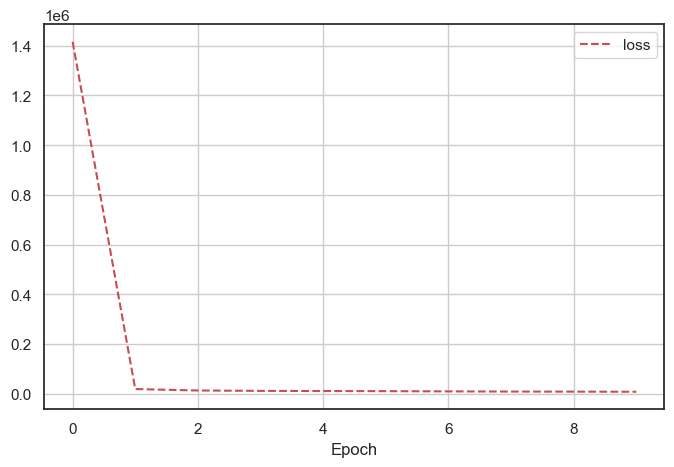

In [77]:
# hist.plot(figsize=(8,5), xlim=[0,29], ylim=[0,1], grid=True, xlabel='Epoch', style=['r--', 'r--.', 'b-', 'b-*'])
hist.plot(figsize=(8,5), grid=True, xlabel='Epoch', style=['r--', 'r--.', 'b-', 'b-*'])

plt.show()

We have created 15 high-impact features using PCA. Now, we use Perceptron to generate predictions for sales.

## Predicting Demand With a Single-Layer Linear Perceptron Algorithm

**Linear Regression**: $Y=w0+w1X1+⋯+wpXp+ε$  
Goal:  find the parameters  w  with the smallest loss

### Solution 1: Matrix Methods (inefficient)

This is the classical solution method for linear regression using matrix methods.  

Recall from calculus, we can take the derivative  
$\frac{dL}{dw}=∇_wL(w)=\frac{1}{n}2X^T(y−Xw)$,   
set it equal to  0  and solve for  $\hat{w}$∗ .

$∇_wL(w)=\frac{1}{n}2X^T(y−Xw)=0$,  
and when you solve for  w  you get  
$\hat{w}=(X^TX)^{-1}X^Ty$.  

Unfortunately, when we have large datasets, which is frequently the case in deep learning applications, some of these matrix operations (especially the matrix inversion) can become problematic and inefficient.  

Later, will see how to solve these minimzation problems in an iterative way that uses the derivative (gradient), that is much more efficient and the key learning algorithm behind all deep learning algorithms.


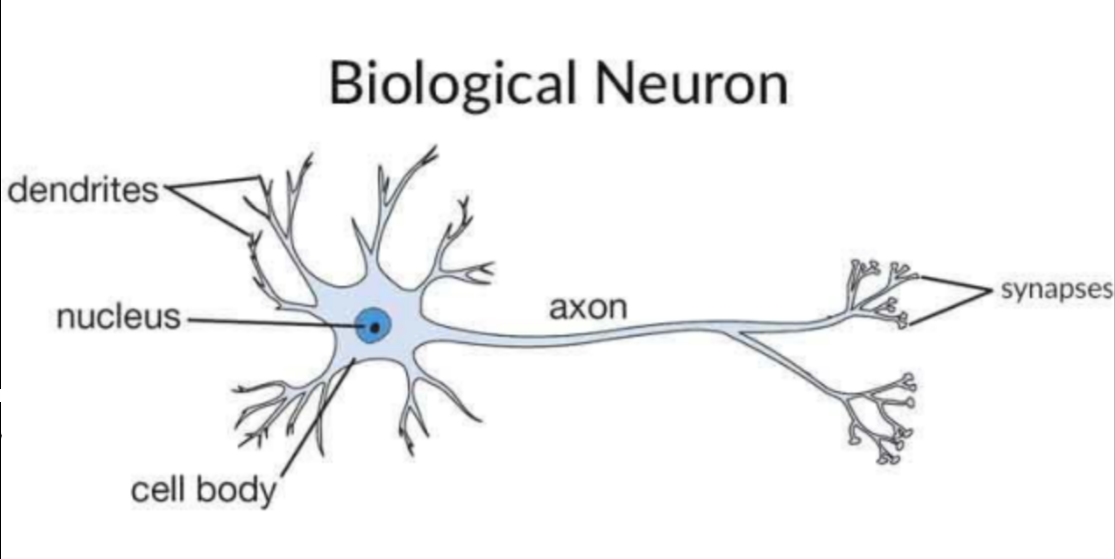

In [78]:
tf.keras.preprocessing.image.load_img(os.path.join(images_path, 'biological_neuron.png'))

## The Perceptron Algorithm

The perceptron is one of the simplest ANN architectures, invented by Frank Rosenblatt in 1957 in The perceptron: A probabilistic model for information storage and organization in the brain.  

It is based on a slightly different artificial neuron (node) called a threshold logic unit (TLU) or a linear threshold unit (LTU).  

The inputs and outputs are numbers rather than binary "on/off" values, and each input connection is associated with a weight.  

The TLU first computes a linear function of its inputs $h = w_1x_1 + w_2x_2 + \cdots w_nx_n + b = w^T x + b, $ it then applies a step function to the result $h_{w,b}(x) = step(w^Tx + b).$  

The most common step function used in perceptrons is the Heaviside step function $h(z)= \mathbb{1}_{\{z \geq 0\}}$, and sometimes the sign function $sgn(z) = \mathbb{1}_{\{z>0\}} - \mathbb{1}_{\{z<0\}}$  

A single TLU (threshold logic unit) can be used for simple linear binary classification.  

It computes a linear function of its inputs, and if the result exceeds a threshold, it outputs the positive class, otherwise, it outputs the negative class.

Threshold: $\sigma (z)$  

Perceptron: $\sigma \text{(}b + \sum_{i=1}^p w_ix_i \text{)}$.  
Want to find: b and $w_i$.  

Single-layer Perceptron:  
- input layer w/ some input units  
- output layer with an output unit  
- no hidden layers  
- each input neuron is connected to the output neuron with weight $w_i$

A perceptron is composed of one or more TLUs organized in a single layer, where every TLU is connected to every input.  

Such a layer is called a fully connected layer or a dense layer.   

The inputs are called the input layer.  
 
Since the layer of the TLUs produce the final outputs, it is called the output layer.

Lots of different threshold functions:  
- Linear  
- piecewise  
- step functions  
- sigmoid  
- softmax  
- ReLU  
etc.

**How is Perceptron trained?**

The perceptron is passed a single training sample at a time, and for each instance it makes a prediction.  

For every output neuron that produced a wrong prediction, it reinforces the connection weights fron the inputs that would have contributed to the correct prediction.  

If error is small, change the weight a little. If large, change the weight a lot.  

**Perceptron can't solve XOR function**  
BUT we can stack Perceptrons to make a multilayer perceptron (MLP)

**Perceptron is AKA single layer linear dense neural network**

## Implementing Linear Regression as a Single-Layer Perceptron

Model:  
Inputs $x_1,...,x_{150}$ passed through PCA $\rightarrow z_1,...z_{15}$.  
Then, $z_1,...,z_{15}$ get weights $w_1,...,w_{15}$, and get an activation function $\sigma$. In this case, $\sigma (z) = z$.  
So, $\hat{Y} = \sigma(\sum_{i=1}^{15} w_i z_i)$

Fairly easy to predict next word given previous words, but sentence structure is a little more complicated.

In [62]:
import tensorflow as tf
lin_reg = tf.keras.Sequential([tf.keras.layers.InputLayer(shape=(X_train_PC_codings.shape[1],)),
                               tf.keras.layers.Normalization(axis=-1), # When -1 the last axis of the input is assumed to be a feature dimension and is normalized per index.
                               tf.keras.layers.Dense(1, activation='linear')])

In [63]:
# This is the model-compilation step
# It specifies the loss function, i.e. the feedback signal for learning the weights
# It specifies the method for updating the weights, that is the optimization method (defaults to SGD)
# It specifies any metrics your model should keep track of at each iteration

lin_reg.compile(loss="mse") # you specify loss, optimizer, and any metrics

In [64]:
# This is built-in training loop
# It iterates over the training data in mini-batches (of some size, say 32 samples) for some number of epochs (an iteration over the entire training data)
# For each batch, the model will compute the gradient of the loss with regard to the weights (which uses the Backpropagation algorithm)
# It then moves the weights in the direction that will reduce the value of the loss for this batch of data

history = lin_reg.fit(X_train_PC_codings, Y_train.values, epochs=3, verbose=True)

Epoch 1/3
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 5s 520us/step - loss: 500663040.0000
Epoch 2/3
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 5s 529us/step - loss: 500659424.0000
Epoch 3/3
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 5s 519us/step - loss: 496470304.0000


In [65]:
lin_reg.predict(X_train_PC_codings)

9165/9165 ━━━━━━━━━━━━━━━━━━━━ 5s 539us/step


array([[17087.904],
       [11709.952],
       [11709.824],
       ...,
       [23019.28 ],
       [23012.924],
       [23013.027]], dtype=float32)

In [66]:
# Returns the loss value & metrics values for the model

lin_reg.evaluate(X_train_PC_codings, Y_train)

9165/9165 ━━━━━━━━━━━━━━━━━━━━ 5s 508us/step - loss: 477221984.0000


499022784.0

In [67]:
lin_reg.layers

[<Normalization name=normalization, built=True>,
 <Dense name=dense_2, built=True>]

In [68]:
lin_reg.layers[1].bias # w_0

<KerasVariable shape=(1,), dtype=float32, path=sequential_3/dense_2/bias>

In [69]:
lin_reg.layers[1].kernel # other w_i's

<KerasVariable shape=(15, 1), dtype=float32, path=sequential_3/dense_2/kernel>

In [70]:
lin_reg.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 15)             │            31 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65 (268.00 B)

 Trainable params: 16 (64.00 B)

 Non-trainable params: 31 (128.00 B)

 Optimizer params: 18 (76.00 B)

## What is Learning?

Learning refers to the process of finding parameters that minimize a loss function (which measures the average error) in an iterative way.  

**Inefficient Way:**  
Guess a bunch of weights randomly, a bajillion times. If you guess enough times, you're guaranteed to find the minimum, but obviously takes a LONG time.

**Gradient Descent:**  
The classical solution method for linear regression is to use matrix methods, i.e. the normal equations, described above.  

Unfortunately, for many technical reasons, this classical calculus methodology of setting a derivative equal to zero and then solving does not work; there are many neural networks that we can't efficiently solve the following equation for:  
$\nabla _w L(w) = 0$.  
- Remember, the loss function $L(w)$ measures the average error, i.e. the average size of mistakes, when we choose parameters $w$.  
- Therefore, the derivative (gradient) $\nabla L(w)$ measures the sensitivity of the average mistakes (error) if you tweak the parameters a little bit.  


**Gradient Descent Process:**  
Incrementally searches for a minimum (specifically, it searches for the weights/parameters that minimize the loss funtion (average size of mistakes)) by:  
- first making an initial guess about where that minimum is $w^{(0)}$  
- next, it finds the direction of steepest descent which is measured by    $-\nabla L(w^{(0)})$  
that is the direction that corresponds to a largest drop in average error if you tweak the weights in that direction  
- then it takes a step in a direction of steepest descent $-\nabla L(w^{(0)})$. The size of the step is controlled by a multiplier $\eta$, so the actual step is:  
$-\eta \nabla L(w^{(0)})$.  
- this results in a new guess about where that minimum is $w^{(1)}$, which is calculated as:  
$w^{(1)} = w^{(0)} - \eta \nabla L(w^{(0)})$.  

This is repeated over and over until the error doesn't change too much $\rightarrow$ **convergence**.

**Iterative methods can get stuck in smaller local minima**  
Overcoming this is challenging. Gradient descent is a method for addressing this issue.

## Back to Demand Forecasting

The optimal price $P^*$ depends on a forecats of demand $\hat{D}$, as well as many other factors:  
$P_t^* = f(\hat{D}_t,..., \text{other factors},...)$  
and is typically the solution to an optimization problem that maximizes a metric such as revenue or profit.  

At this point, we have generated a demand forecast for weekly sales:  
$\hat{D}(X_1^{PC},...,X_p^{PC}) = X^{PC} \hat{w}$  
using a single-layer perceptron algorithm (linear regression) with features generated using the PCA algorithm.

## Optimization

**Convex vs. Nonconvex Optimization**  
Shallow learning minimzation problems (linear regression, decision trees, etc.) are convex $\rightarrow$ have a single local minimum (global minimum).  

Many deep learning minimzation problems are **non-convex** and of these, many do **not have a single local minimum**.  

No guarantee that the algorithm will reach the global minimum point; may get **stuck** in local minima.  

**Non-convexity of DL algorithms** is a key reason why training DL algorithms is such a hard problem.  

**Engine of DL:** gradient-based optimization

### Computing Gradients with TF's Gradient Tape API

How do we actually compute $\nabla L(w)$?  

**Backpropagation:** automatically compute the gradient of loss functions from neural networks.  

The API through which we can access TF's powerful automatic differentiation software is called the **Gradient Tape API**.  
- In other words, GradientTape is TensorFlow's software implementation of the backpropagation algorithm for computing gradients of functions.  

GradientTape is a Python **scope** that will **record** the operations (i.e. the loss function) that run inside of the scope in the form of a computation graph (flowchart, also called a tape).  

This graph can be used to retrieve the gradient of any output with respect to any variable(s) (e.g. the parameter weights) that must be **tf.Variable() objects.**

In [71]:
# Initialize the weight w as a TensorFlow variable object
# A TF variable is a specific kind of variable that are allowed to be changed (i.e. they are mutable), such as the weights of a NN

# Tip: always use floats for TF variable objects (will retun None if use tf.Variable(0))
w = tf.Variable(0.0)

# Open a GradientTape scope
with tf.GradientTape() as tape:
  # Inside the scope, apply functions to the variable whose operations we want to keep track of, and their derivatives, so we can eventually differentiate
  L = 2*w + 3

# Use the record of computations (the tape) to retrieve dL/dw(0) the derivative of L with respect to the variable w (which is initialized at 0)
derivative_of_L_wrt_w = tape.gradient(L, w)

derivative_of_L_wrt_w

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

In [72]:
print(derivative_of_L_wrt_w)

tf.Tensor(2.0, shape=(), dtype=float32)


Let's try $L(w) = w^2$

In [73]:
w = tf.Variable(3.0)
with tf.GradientTape() as tape:
    L = w**2
dL_dw = tape.gradient(L, w)
dL_dw

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

Questions:  
- isn't GD an iterative method? How does it avoid other local minima?  
- how deep will we have to understand these methods?  
- could you go over PCA in a little more detail?  
- 